# Обучение сети c несколькими параметрами

Параметры обучения: Vgs, Vds, L, W, Temp

In [1]:
import numpy as np
import pandas as pd
import time

In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [3]:
# !python -m pip install tensorflow

Загружаем свой датасет


In [194]:
# df = pd.read_csv('mosfet.csv')

In [195]:
df = pd.read_csv('mosfet_complicated.csv')

In [196]:
df.shape

(14040, 6)

In [197]:
df.describe()

,Vds,Vgs,L,W,T,Id
count,14040.000000,14040.000000,1.404000e+04,1.404000e+04,14040.000000,1.404000e+04
mean,1.319639,1.846154,5.333333e-07,5.333333e-07,25.000000,1.908705e-04
std,0.823151,0.843777,3.399467e-07,3.399467e-07,20.413141,2.136075e-04
min,0.172169,0.250000,2.000000e-07,2.000000e-07,0.000000,2.587673e-10
25%,0.600000,1.250000,2.000000e-07,2.000000e-07,0.000000,3.672029e-05
50%,1.200000,2.000000,4.000000e-07,4.000000e-07,25.000000,1.198960e-04
75%,1.922169,2.500000,1.000000e-06,1.000000e-06,50.000000,2.727487e-04
max,2.922169,3.000000,1.000000e-06,1.000000e-06,50.000000,1.211445e-03


In [198]:
df['Vds'].unique() 

array([0.2       , 0.7       , 1.2       , 1.7       , 2.2       ,
       2.7       , 0.17216897, 0.67216897, 1.17216897, 1.67216897,
       2.17216897, 2.67216897, 0.4       , 0.42216897, 0.92216897,
       1.42216897, 1.92216897, 2.42216897, 2.92216897, 0.6       ,
       0.8       , 1.        , 1.4       , 1.6       , 1.8       ,
       2.        ])

In [199]:
df['L'].unique() 

array([2.e-07, 4.e-07, 1.e-06])

In [200]:
df['W'].unique() 

array([2.e-07, 4.e-07, 1.e-06])

In [201]:
df['T'].unique() 

array([ 0., 25., 50.])

## Подготовка данных

Подготовим входные данные и заменим нули

In [202]:
df[df['Id'] != 0.0]['Id'].min()

2.5876728346749347e-10

In [203]:
df[df['Vgs'] != 0.0]['Vgs'].min()

0.25

In [204]:
df[df['Vds'] != 0.0]['Vds'].min()

0.1721689658555838

In [205]:
REPLACE_ZERO_ID = 1e-15
REPLACE_ZERO_VGS = 1e-3
REPLACE_ZERO_VDS = 1e-3
# REPLACE_ZERO_T = 0.1
# SHIFT_T = 30

In [206]:
# # замена отрицательных значений на нули
# df.loc[df["Id"] < 0, "Id"] = 0

In [208]:
# # Replace zeros
# # df[df["Id"] < 0] = 0
# df["Id"].replace({0:REPLACE_ZERO_ID}, inplace=True)
# df["Vgs"].replace({0:REPLACE_ZERO_VGS}, inplace=True)
# df["Vds"].replace({0:REPLACE_ZERO_VDS}, inplace=True)
# # df["T"].replace({0:REPLACE_ZERO_T}, inplace=True)

# # fix negative numbers
# df["T"] += SHIFT_T

In [209]:
id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]
L=df["L"]
W=df["W"]
T=df["T"]


y_raw=np.ravel(id)
X_raw=df.iloc[:,0:5]

In [210]:
X_raw

,Vds,Vgs,L,W,T
0,0.200000,0.25,2.000000e-07,2.000000e-07,0.0
1,0.700000,0.25,2.000000e-07,2.000000e-07,0.0
2,1.200000,0.25,2.000000e-07,2.000000e-07,0.0
3,1.700000,0.25,2.000000e-07,2.000000e-07,0.0
4,2.200000,0.25,2.000000e-07,2.000000e-07,0.0
...,...,...,...,...,...
14035,1.600000,3.00,1.000000e-06,1.000000e-06,50.0
14036,1.800000,3.00,1.000000e-06,1.000000e-06,50.0
14037,2.000000,3.00,1.000000e-06,1.000000e-06,50.0
14038,2.172169,3.00,1.000000e-06,1.000000e-06,50.0


In [211]:
from sklearn import preprocessing

In [212]:
# scaler = preprocessing.StandardScaler().fit(X_raw)
# X_scaled = scaler.transform(X_raw)

Подействуем десятичным логарифмом на столбцы напряжений

In [213]:
X_log = X_raw.copy()
X_log['Vds'] = X_log['Vds'].apply(np.log10)
X_log['Vgs'] = X_log['Vgs'].apply(np.log10)
X_log

,Vds,Vgs,L,W,T
0,-0.698970,-0.602060,2.000000e-07,2.000000e-07,0.0
1,-0.154902,-0.602060,2.000000e-07,2.000000e-07,0.0
2,0.079181,-0.602060,2.000000e-07,2.000000e-07,0.0
3,0.230449,-0.602060,2.000000e-07,2.000000e-07,0.0
4,0.342423,-0.602060,2.000000e-07,2.000000e-07,0.0
...,...,...,...,...,...
14035,0.204120,0.477121,1.000000e-06,1.000000e-06,50.0
14036,0.255273,0.477121,1.000000e-06,1.000000e-06,50.0
14037,0.301030,0.477121,1.000000e-06,1.000000e-06,50.0
14038,0.336894,0.477121,1.000000e-06,1.000000e-06,50.0


Теперь нормируем все значений по столбцам

In [214]:
scaler = preprocessing.StandardScaler().fit(X_log)
X_scaled = scaler.transform(X_log)

Среднее каждого столбца должно быть равно 0

In [215]:
X_scaled.mean(axis=0)

array([ 1.41703679e-17, -6.47788249e-17,  1.21460297e-17, -3.23894125e-17,
        1.01216914e-18])

Отклонение должны быть равны 1

In [216]:
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1.])

Нормализуем выходные данные

In [217]:
#Normalize data before training

X = X_scaled
y=-1/np.log10(y_raw)

In [218]:
X

array([[-1.9907235 , -2.74738059, -0.98058068, -0.98058068, -1.22474487],
       [-0.45097372, -2.74738059, -0.98058068, -0.98058068, -1.22474487],
       [ 0.21149776, -2.74738059, -0.98058068, -0.98058068, -1.22474487],
       ...,
       [ 0.8393449 ,  0.97777849,  1.37281295,  1.37281295,  1.22474487],
       [ 0.94084137,  0.97777849,  1.37281295,  1.37281295,  1.22474487],
       [ 1.1954635 ,  0.97777849,  1.37281295,  1.37281295,  1.22474487]])

**Разделение набора данных на обучающий и тестовый наборы**

In [219]:
# !pip install sklearn

In [220]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Нормализуем значения $I_d$ так чтобы выходные значения были в пределах 0 и 1

In [221]:
y_train=y_train.reshape(-1,1) #reshape the data before feeding to network
y_test=y_test.reshape(-1,1)

## Построение модели

**Import Tensorflow and Keras**

In [222]:
import tensorflow as tf
from tensorflow import keras

In [223]:
tf.test.gpu_device_name()

'/device:GPU:0'

Note: Relu as activation finction may be used for hidden layers but result might not be smooth. For any compact model, it should be continuous so that it is compatible with Newton algorithm which is used in SPICE simulators.

In [224]:
# We'll use Keras to create a Neural network

# 1 - 100 - 100 - 50 - 1

model_relu = tf.keras.Sequential()

model_relu.add(keras.layers.Dense(100, activation='relu', input_shape=(5,)))
model_relu.add(keras.layers.Dense(100, activation='relu'))
model_relu.add(keras.layers.Dense(50, activation='relu'))
model_relu.add(keras.layers.Dense(1, activation='sigmoid'))

model_relu.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_relu.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 100)               600       
                                                                 
 dense_23 (Dense)            (None, 100)               10100     
                                                                 
 dense_24 (Dense)            (None, 50)                5050      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 15,801
Trainable params: 15,801
Non-trainable params: 0
_________________________________________________________________


In [225]:
t1 = time.perf_counter()

history_relu = model_relu.fit(X_train, y_train, 
                      epochs=1000, 
                      validation_data=(X_test, y_test),
                      batch_size=64,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
176/176 [==============================] - 1s 4ms/step - loss: 0.0024 - mae: 0.0286 - val_loss: 3.2648e-04 - val_mae: 0.0138
Epoch 2/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.7348e-04 - mae: 0.0096 - val_loss: 7.2596e-05 - val_mae: 0.0063
Epoch 3/1000
176/176 [==============================] - 1s 3ms/step - loss: 3.6977e-05 - mae: 0.0045 - val_loss: 1.9334e-05 - val_mae: 0.0034
Epoch 4/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.3960e-05 - mae: 0.0028 - val_loss: 1.0947e-05 - val_mae: 0.0025
Epoch 5/1000
176/176 [==============================] - 1s 3ms/step - loss: 9.2271e-06 - mae: 0.0023 - val_loss: 8.1822e-06 - val_mae: 0.0022
Epoch 6/1000
176/176 [==============================] - 1s 3ms/step - loss: 7.1807e-06 - mae: 0.0020 - val_loss: 7.1571e-06 - val_mae: 0.0021
Epoch 7/1000
176/176 [==============================] - 1s 3ms/step - loss: 6.0746e-06 - mae: 0.0019 - val_loss: 5.5077e-06 - val_mae: 0.0018
Epoch 8/10

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 8.6880e-07 - mae: 7.1408e-04 - val_loss: 9.6505e-07 - val_mae: 7.5774e-04
time taken to run: 742.4782873720001

Пропуск ----

Для идеальной модели:

87/87 [==============================] - 0s 4ms/step - loss: 8.4781e-06 - mae: 0.0013 - val_loss: 1.2999e-05 - val_mae: 0.0017
time taken to run: 382.523476308

In [226]:
# We'll use Keras to create a Neural network

# 5 - 100 - 100 - 50 - 1

model_tanh = tf.keras.Sequential()

model_tanh.add(keras.layers.Dense(100, activation='tanh', input_shape=(5,)))
model_tanh.add(keras.layers.Dense(100, activation='tanh'))
model_tanh.add(keras.layers.Dense(50, activation='tanh'))
model_tanh.add(keras.layers.Dense(1, activation='sigmoid'))

model_tanh.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_tanh.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 100)               600       
                                                                 
 dense_27 (Dense)            (None, 100)               10100     
                                                                 
 dense_28 (Dense)            (None, 50)                5050      
                                                                 
 dense_29 (Dense)            (None, 1)                 51        
                                                                 
Total params: 15,801
Trainable params: 15,801
Non-trainable params: 0
_________________________________________________________________


In [227]:
t1 = time.perf_counter()

history_2 = model_tanh.fit(X_train, y_train, 
                      epochs=1000, 
                      validation_data=(X_test, y_test),
                      batch_size=64,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
176/176 [==============================] - 1s 4ms/step - loss: 0.0050 - mae: 0.0363 - val_loss: 1.6168e-04 - val_mae: 0.0102
Epoch 2/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.2189e-04 - mae: 0.0088 - val_loss: 9.3208e-05 - val_mae: 0.0078
Epoch 3/1000
176/176 [==============================] - 1s 3ms/step - loss: 7.9069e-05 - mae: 0.0071 - val_loss: 6.6360e-05 - val_mae: 0.0064
Epoch 4/1000
176/176 [==============================] - 1s 3ms/step - loss: 5.7622e-05 - mae: 0.0060 - val_loss: 5.5556e-05 - val_mae: 0.0059
Epoch 5/1000
176/176 [==============================] - 1s 3ms/step - loss: 4.4100e-05 - mae: 0.0053 - val_loss: 3.3819e-05 - val_mae: 0.0046
Epoch 6/1000
176/176 [==============================] - 1s 3ms/step - loss: 3.3615e-05 - mae: 0.0046 - val_loss: 2.8572e-05 - val_mae: 0.0043
Epoch 7/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.7668e-05 - mae: 0.0042 - val_loss: 2.4047e-05 - val_mae: 0.0039
Epoch 8/10

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.1201e-06 - mae: 8.0845e-04 - val_loss: 8.9485e-07 - val_mae: 7.1164e-04
time taken to run: 742.2834229219998

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.0978e-06 - mae: 7.9945e-04 - val_loss: 9.7938e-07 - val_mae: 7.5660e-04
time taken to run: 742.3116083930001

Для идеальной модели:

Epoch 1000/1000
87/87 [==============================] - 0s 4ms/step - loss: 6.6572e-06 - mae: 0.0011 - val_loss: 1.2065e-05 - val_mae: 0.0011
time taken to run: 419.6870692130001

In [228]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model_srelu = tf.keras.Sequential()

model_srelu.add(keras.layers.Dense(32, activation='relu', input_shape=(5,)))
model_srelu.add(keras.layers.Dense(16, activation='relu'))
model_srelu.add(keras.layers.Dense(1, activation='sigmoid'))

model_srelu.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_srelu.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                192       
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (None, 1)                 17        
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [229]:
t1 = time.perf_counter()

history_3 = model_srelu.fit(X_train, y_train, 
                      epochs=1000, 
                      validation_data=(X_test, y_test),
                      batch_size=64,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
176/176 [==============================] - 1s 3ms/step - loss: 0.0250 - mae: 0.1117 - val_loss: 0.0012 - val_mae: 0.0278
Epoch 2/1000
176/176 [==============================] - 1s 3ms/step - loss: 7.7082e-04 - mae: 0.0221 - val_loss: 5.3577e-04 - val_mae: 0.0183
Epoch 3/1000
176/176 [==============================] - 1s 3ms/step - loss: 4.5766e-04 - mae: 0.0169 - val_loss: 3.7967e-04 - val_mae: 0.0154
Epoch 4/1000
176/176 [==============================] - 1s 3ms/step - loss: 3.3954e-04 - mae: 0.0146 - val_loss: 2.9887e-04 - val_mae: 0.0136
Epoch 5/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.6953e-04 - mae: 0.0129 - val_loss: 2.4139e-04 - val_mae: 0.0121
Epoch 6/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.1870e-04 - mae: 0.0117 - val_loss: 1.9797e-04 - val_mae: 0.0110
Epoch 7/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.7795e-04 - mae: 0.0105 - val_loss: 1.6087e-04 - val_mae: 0.0100
Epoch 8/1000
1

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.0801e-06 - mae: 8.0254e-04 - val_loss: 1.0456e-06 - val_mae: 7.8396e-04
time taken to run: 742.390078684

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.0795e-06 - mae: 8.0184e-04 - val_loss: 1.1785e-06 - val_mae: 8.5106e-04
time taken to run: 742.2629364119998

Для идеальной модели:

Epoch 1000/1000
87/87 [==============================] - 0s 4ms/step - loss: 1.1614e-05 - mae: 0.0020 - val_loss: 1.3253e-05 - val_mae: 0.0019

In [230]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model_stanh = tf.keras.Sequential()

model_stanh.add(keras.layers.Dense(32, activation='tanh', input_shape=(5,)))
model_stanh.add(keras.layers.Dense(16, activation='tanh'))
model_stanh.add(keras.layers.Dense(1, activation='sigmoid'))

model_stanh.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_stanh.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                192       
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [231]:
t1 = time.perf_counter()

history_4 = model_stanh.fit(X_train, y_train, 
                      epochs=1000, 
                      validation_data=(X_test, y_test),
                      batch_size=64,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
176/176 [==============================] - 1s 4ms/step - loss: 0.0127 - mae: 0.0774 - val_loss: 5.5640e-04 - val_mae: 0.0176
Epoch 2/1000
176/176 [==============================] - 1s 3ms/step - loss: 4.4511e-04 - mae: 0.0162 - val_loss: 3.9296e-04 - val_mae: 0.0149
Epoch 3/1000
176/176 [==============================] - 1s 3ms/step - loss: 3.2041e-04 - mae: 0.0137 - val_loss: 2.9485e-04 - val_mae: 0.0127
Epoch 4/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.5135e-04 - mae: 0.0121 - val_loss: 2.3369e-04 - val_mae: 0.0117
Epoch 5/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.0877e-04 - mae: 0.0111 - val_loss: 1.9485e-04 - val_mae: 0.0107
Epoch 6/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.7794e-04 - mae: 0.0103 - val_loss: 1.6737e-04 - val_mae: 0.0098
Epoch 7/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.5447e-04 - mae: 0.0096 - val_loss: 1.4461e-04 - val_mae: 0.0091
Epoch 8/10

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.0600e-06 - mae: 7.9546e-04 - val_loss: 8.8435e-07 - val_mae: 7.0884e-04
time taken to run: 742.277444327

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.0642e-06 - mae: 7.9699e-04 - val_loss: 1.1635e-06 - val_mae: 8.2856e-04
time taken to run: 742.2452093909997

Для идеальной модели:

Epoch 1000/1000
87/87 [==============================] - 0s 4ms/step - loss: 1.0173e-05 - mae: 0.0016 - val_loss: 1.2021e-05 - val_mae: 0.0016

Сохраним веса в виде файла

### Создадим сеть с другой архитектурой

P.S. Пока не обучалось

In [232]:
# Сreate another Neural network

# 2 - 16 - 8 - 4 - 1

model_mtanh = tf.keras.Sequential()

model_mtanh.add(keras.layers.Dense(32, activation='tanh', input_shape=(5,)))
model_mtanh.add(keras.layers.Dense(16, activation='tanh'))
model_mtanh.add(keras.layers.Dense(8,activation='tanh'))
model_mtanh.add(keras.layers.Dense(1, activation='sigmoid'))

model_mtanh.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_mtanh.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 32)                192       
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [233]:
t1 = time.perf_counter()

history_5 = model_mtanh.fit(X_train, y_train, 
                      epochs=1000, 
                      validation_data=(X_test, y_test),
                      batch_size=64,
                      shuffle=True,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/1000
176/176 [==============================] - 1s 4ms/step - loss: 0.0100 - mae: 0.0628 - val_loss: 5.0569e-04 - val_mae: 0.0176
Epoch 2/1000
176/176 [==============================] - 1s 3ms/step - loss: 4.2006e-04 - mae: 0.0160 - val_loss: 3.6011e-04 - val_mae: 0.0149
Epoch 3/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.9859e-04 - mae: 0.0135 - val_loss: 2.5784e-04 - val_mae: 0.0125
Epoch 4/1000
176/176 [==============================] - 1s 3ms/step - loss: 2.1991e-04 - mae: 0.0116 - val_loss: 1.9133e-04 - val_mae: 0.0107
Epoch 5/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.6617e-04 - mae: 0.0102 - val_loss: 1.5046e-04 - val_mae: 0.0096
Epoch 6/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.2752e-04 - mae: 0.0089 - val_loss: 1.1488e-04 - val_mae: 0.0085
Epoch 7/1000
176/176 [==============================] - 1s 3ms/step - loss: 1.0143e-04 - mae: 0.0080 - val_loss: 9.0835e-05 - val_mae: 0.0075
Epoch 8/10

Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 9.5118e-07 - mae: 7.4268e-04 - val_loss: 1.0357e-06 - val_mae: 7.8521e-04
time taken to run: 802.2765295859999



Epoch 1000/1000
243/243 [==============================] - 1s 3ms/step - loss: 1.0253e-06 - mae: 7.7591e-04 - val_loss: 1.2506e-06 - val_mae: 8.4358e-04
time taken to run: 802.2900276769997

Для идеальной модели:

Epoch 1000/1000
87/87 [==============================] - 0s 4ms/step - loss: 9.8540e-06 - mae: 0.0015 - val_loss: 1.2407e-05 - val_mae: 0.0018
time taken to run: 443.37020051000036

#### Cохраним веса

In [234]:
model_relu.save("model_relu.h5") # save weights

In [235]:
model_tanh.save("model_tanh.h5")

In [236]:
model_srelu.save("model_srelu.h5")

In [237]:
model_stanh.save("model_stanh.h5")

In [238]:
model_mtanh.save("model_mtanh.h5")

Загрузим веса из файла (по необходимости)

In [239]:
model_relu.load_weights("model_relu.h5") # load weights

In [ ]:
model_tanh.load_weights("model_tanh.h5")

In [ ]:
model_srelu.load_weights("model_srelu.h5")

In [ ]:
model_stanh.load_weights("model_stanh.h5")

In [ ]:
model_mtanh.load_weights("model_mtanh.h5")

### **Построим графики loss моделей**

In [493]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [242]:
def show_history(history, SKIP=200, title='Training and validation loss'):
  d = 5
  # Exclude the first few epochs so the graph is easier to read
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  x = epochs[SKIP::5]

  plt.plot(x, loss[SKIP::5], 'g.', label='Training loss')
  plt.plot(x, val_loss[SKIP::5], 'b.', label='Validation loss')

  theta = np.polyfit(x, loss[SKIP::5], deg= d)
  model = np.poly1d(theta)
  plt.plot(x, model(x))

  theta = np.polyfit(x, val_loss[SKIP::5], deg= d)
  model = np.poly1d(theta)
  plt.plot(x, model(x))

  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()  

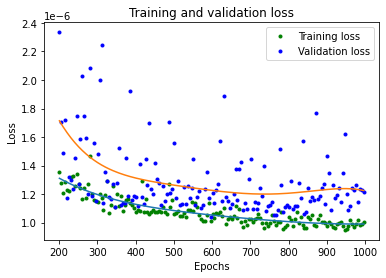

In [243]:
show_history(history_relu)

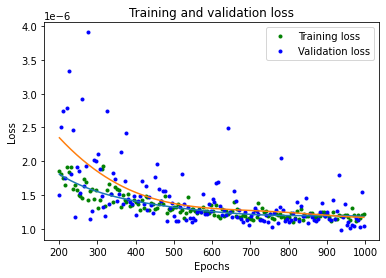

In [244]:
show_history(history_2)

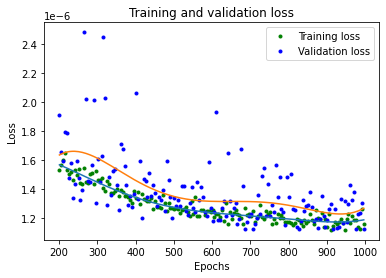

In [245]:
show_history(history_3)

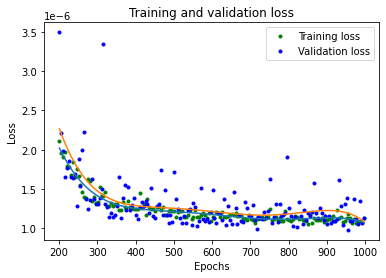

In [246]:
show_history(history_4)

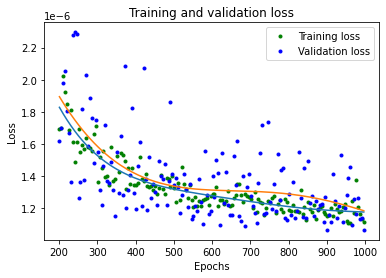

In [247]:
show_history(history_5)

## Тестирование обученной сети

Применим новые данные, на которых сеть не обучалась. 

При этом не забудем про подготовку входных и выходных параметров. 

In [398]:
def process_data(df):
  """Функция преобразования входных и выходных данных"""

  # Replace zeros
  df.loc[df["Id"] < 0, "Id"] = 0
  # df["Id"].replace({0:REPLACE_ZERO_ID}, inplace=True)
  # df["Vgs"].replace({0:REPLACE_ZERO_VGS}, inplace=True)
  # df["Vds"].replace({0:REPLACE_ZERO_VDS}, inplace=True)

# заменим нули на что-то другое
  df["Id"].replace({0:1e-20}, inplace=True)
  df["Vgs"].replace({0:0.1}, inplace=True)
  df["Vds"].replace({0:0.1}, inplace=True)

  id=df["Id"]
  Vgs=df["Vgs"]
  Vds=df["Vds"]
  L=df["L"]
  W=df["W"]
  T=df["T"]

# разделим на X и Y
  ynew=np.ravel(id)
  xnew=df.iloc[:,0:5]

# поддействует десятичным логарифмом на напряжения
  xlog = xnew.copy()
  xlog['Vds'] = xlog['Vds'].apply(np.log10)
  xlog['Vgs'] = xlog['Vgs'].apply(np.log10)

# применим преобразования что и при нормировке
  xval = scaler.transform(xlog)

# нормируем выходные данные
  yval=-1/np.log10(ynew)
  yval=yval.reshape(-1,1)

  return xval, yval, df

In [399]:
df1 = pd.read_csv('mosfet_val_3.csv')

In [400]:
# df1 = df1[df1['Vgs'] == 1]
df1

,Vds,Vgs,L,W,T,Id
0,0.0,0.1,2.000000e-07,2.000000e-07,25.0,1.416814e-27
1,0.1,0.1,2.000000e-07,2.000000e-07,25.0,9.029534e-12
2,0.2,0.1,2.000000e-07,2.000000e-07,25.0,1.029902e-11
3,0.3,0.1,2.000000e-07,2.000000e-07,25.0,1.146130e-11
4,0.4,0.1,2.000000e-07,2.000000e-07,25.0,1.265098e-11
...,...,...,...,...,...,...
56,5.6,0.1,2.000000e-07,2.000000e-07,25.0,3.568931e-10
57,5.7,0.1,2.000000e-07,2.000000e-07,25.0,3.769632e-10
58,5.8,0.1,2.000000e-07,2.000000e-07,25.0,3.981087e-10
59,5.9,0.1,2.000000e-07,2.000000e-07,25.0,4.203854e-10


In [401]:
xval, yval, df1 = process_data(df1)

**Plot actual vs. predicted result. Make sure that predicted drain current is de-normalized before plotting.**

*De-normalization required because before feeding to network (training phase), we have converted drain current within 0 to 1 range  so that Sigmoid function can operate. So, predicted current value will be within same range. It should be converted back to it's original form (De-normalization)*

In [402]:
def show_val(xval, yval, df):
  """Функция графиков валидационных кривых"""
  vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
  vg=np.ravel(vg1)
  vg=vg.reshape(-1,1)
  plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')

  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()

In [403]:
def show_pred(model, xval, df, name='', begin=0):
  """Функция графиков предскасказаний сети"""
  # Predict the new dataset
  y_pred = model.predict(xval)
  #plot the result
  vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
  vg=np.ravel(vg1)
  vg=vg.reshape(-1,1)

  plt.plot(vg[begin:], 10**(-1/y_pred)[begin:], label='Predicted ' + name)

Вспомним что область обучения лежала в пределах 0 до 5 для напржений

In [404]:
df1 = pd.read_csv('mosfet_val_3.csv')
xval, yval, df1 = process_data(df1)

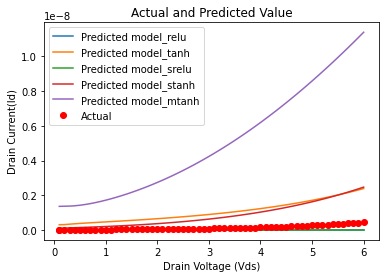

In [405]:
show_pred(model_relu, xval, df1, 'model_relu')
show_pred(model_tanh, xval, df1, 'model_tanh')
show_pred(model_srelu, xval, df1, 'model_srelu')
show_pred(model_stanh, xval, df1, 'model_stanh')
show_pred(model_mtanh, xval, df1, 'model_mtanh')
show_val(xval, yval, df1)

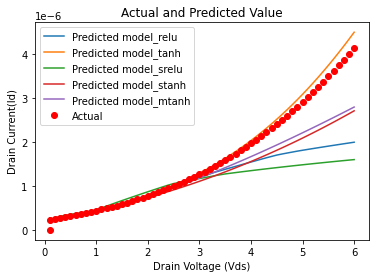

In [406]:
df1 = pd.read_csv('mosfet_val_4.csv')
xval, yval, df1 = process_data(df1)
show_pred(model_relu, xval, df1, 'model_relu')
show_pred(model_tanh, xval, df1, 'model_tanh')
show_pred(model_srelu, xval, df1, 'model_srelu')
show_pred(model_stanh, xval, df1, 'model_stanh')
show_pred(model_mtanh, xval, df1, 'model_mtanh')
show_val(xval, yval, df1)

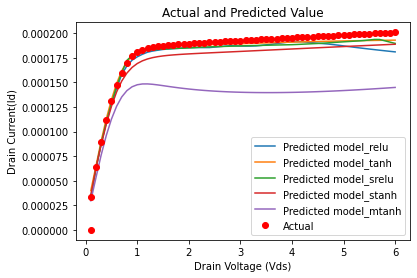

In [407]:
df1 = pd.read_csv('mosfet_val_5.csv')
xval, yval, df1 = process_data(df1)
show_pred(model_relu, xval, df1, 'model_relu')
show_pred(model_tanh, xval, df1, 'model_tanh')
show_pred(model_srelu, xval, df1, 'model_srelu')
show_pred(model_stanh, xval, df1, 'model_stanh')
show_pred(model_mtanh, xval, df1, 'model_mtanh')
show_val(xval, yval, df1)

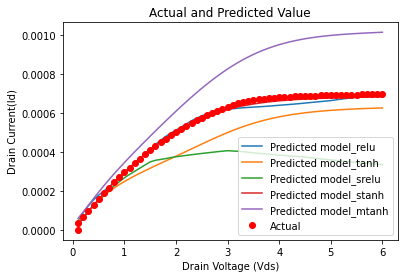

In [408]:
df1 = pd.read_csv('mosfet_val_6.csv')
xval, yval, df1 = process_data(df1)
show_pred(model_relu, xval, df1, 'model_relu')
show_pred(model_tanh, xval, df1, 'model_tanh')
show_pred(model_srelu, xval, df1, 'model_srelu')
show_pred(model_stanh, xval, df1, 'model_stanh')
show_pred(model_mtanh, xval, df1, 'model_mtanh')
show_val(xval, yval, df1)

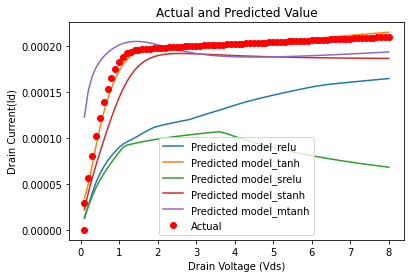

In [409]:
df1 = pd.read_csv('mosfet_val_7.csv')
xval, yval, df1 = process_data(df1)
show_pred(model_relu, xval, df1, 'model_relu')
show_pred(model_tanh, xval, df1, 'model_tanh')
show_pred(model_srelu, xval, df1, 'model_srelu')
show_pred(model_stanh, xval, df1, 'model_stanh')
show_pred(model_mtanh, xval, df1, 'model_mtanh')
show_val(xval, yval, df1)

In [502]:
def show_pred_grad(model, xval, df, x, name='', begin=1):
  """Функция графика производной предсказания сети"""
  # Predict the new dataset
  y_pred = model.predict(xval)
  vg1=df[x] #change this index to vgs if you are going to plot Id-Vg
  y_pred = np.array(10**(-1/y_pred)[begin:])

  # plt.plot(vg1[begin:], np.gradient(10**(-1/y_pred)[begin:]), label='Predicted ' + name)
  plt.plot(vg1[begin:], np.gradient(np.ravel(y_pred)), label='Predicted ' + name)

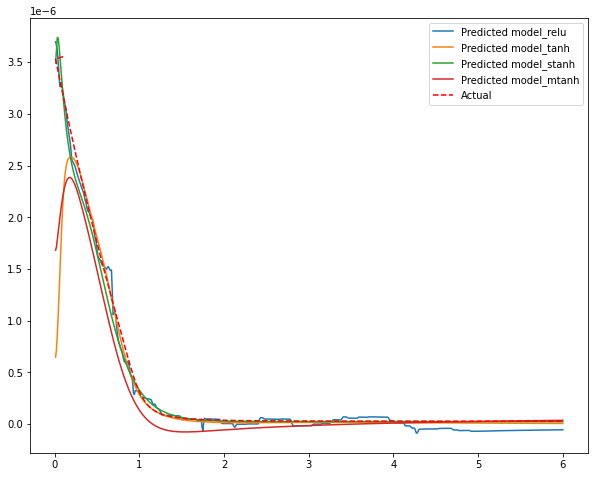

In [506]:
df1 = pd.read_csv('mosfet_val_8.csv')
xval, yval, df_ = process_data(df1)

fig, ax = plt.subplots(figsize=(10, 8))

show_pred_grad(model_relu, xval, df1, 'Vds',  'model_relu')
show_pred_grad(model_tanh, xval, df1, 'Vds', 'model_tanh')
# show_pred_grad(model_srelu, xval, df1, 'Vds', 'model_srelu')
show_pred_grad(model_stanh, xval, df1, 'Vds', 'model_stanh')
show_pred_grad(model_mtanh, xval, df1, 'Vds', 'model_mtanh')
# show_val_grad(xval, yval, df1)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

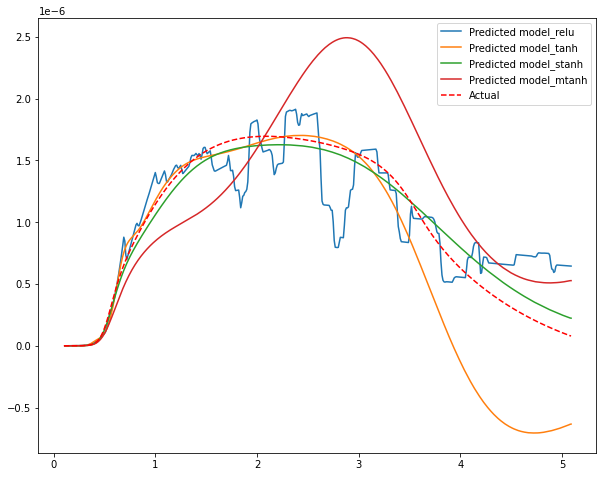

In [508]:
df1 = pd.read_csv('mosfet_val_9.csv')
xval, yval, df_ = process_data(df1)

fig, ax = plt.subplots(figsize=(10, 8))

show_pred_grad(model_relu, xval, df1, 'Vgs',  'model_relu')
show_pred_grad(model_tanh, xval, df1, 'Vgs', 'model_tanh')
# show_pred_grad(model_srelu, xval, df1, 'Vgs', 'model_srelu')
show_pred_grad(model_stanh, xval, df1, 'Vgs', 'model_stanh')
show_pred_grad(model_mtanh, xval, df1, 'Vgs', 'model_mtanh')
# show_val_grad(xval, yval, df1)
plt.plot(df1['Vgs'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Посчитаем MSE для валиадционных данных внутри области обчения

In [410]:
df_val = pd.read_csv('mosfet_val_0.csv')

Посмотрим на область в которой будем считать ошибку

Область напряжений:

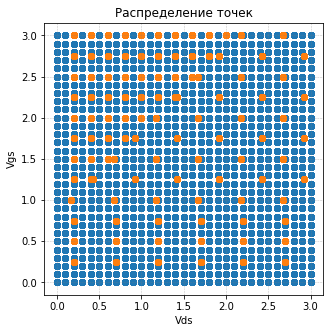

In [411]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['Vds']
y_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

Область технических параметров транзисторов:

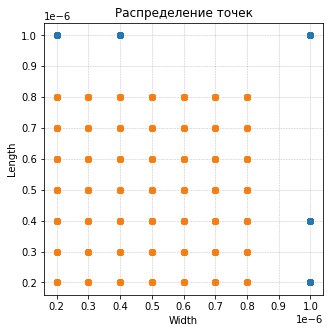

In [412]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['W']
y_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

Посчитаем сред квадр ошибку внутри области обучения

In [413]:
def print_loss(df_val, model):
  xval, yval, df_val = process_data(df_val)
  y_pred = model.predict(xval)
  loss_postproc = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred))
  loss = keras.losses.MSE(yval, y_pred)
  print('max loss: ', np.max(loss))
  print('max post-proc loss: ', np.max(loss_postproc))
  loss_mean = tf.reduce_mean(loss_postproc) # Рассчитать среднеквадратичную ошибку партии
  print('mean post-prox loss: ', loss_mean)

In [414]:
print_loss(df_val, model_relu)

max loss:  0.045160946
max post-proc loss:  1.679956e-08
mean post-prox loss:  tf.Tensor(1.9139378e-10, shape=(), dtype=float32)


max loss:  0.016918585
max post-proc loss:  3.2885346e-08
mean post-prox loss:  tf.Tensor(6.402977e-10, shape=(), dtype=float32)

max loss:  0.046162337
max post-proc loss:  1.8371873e-08
mean post-prox loss:  tf.Tensor(2.2785156e-10, shape=(), dtype=float32)

14716/14716 [==============================] - 32s 2ms/step
max loss:  0.0013038516
max post-proc loss:  9.769596e-09
mean post-prox loss:  tf.Tensor(4.2312298e-10, shape=(), dtype=float32)

In [415]:
print_loss(df_val, model_tanh)

max loss:  0.044919893
max post-proc loss:  2.051837e-08
mean post-prox loss:  tf.Tensor(1.09065666e-10, shape=(), dtype=float32)


max loss:  0.031422645
max post-proc loss:  2.69631e-09
mean post-prox loss:  tf.Tensor(5.0194644e-11, shape=(), dtype=float32)

max loss:  0.051119633
max post-proc loss:  5.767204e-08
mean post-prox loss:  tf.Tensor(5.132279e-10, shape=(), dtype=float32)

14716/14716 [==============================] - 33s 2ms/step
max loss:  0.001361964
max post-proc loss:  1.7015108e-08
mean post-prox loss:  tf.Tensor(8.278366e-10, shape=(), dtype=float32)

In [416]:
print_loss(df_val, model_srelu)

max loss:  0.047600932
max post-proc loss:  1.719647e-08
mean post-prox loss:  tf.Tensor(3.5402725e-10, shape=(), dtype=float32)


max loss:  0.017615225
max post-proc loss:  3.097965e-08
mean post-prox loss:  tf.Tensor(9.191279e-10, shape=(), dtype=float32)

max loss:  0.045374084
max post-proc loss:  2.3640478e-08
mean post-prox loss:  tf.Tensor(2.1709755e-10, shape=(), dtype=float32)

14716/14716 [==============================] - 21s 1ms/step
max loss:  0.001631434
max post-proc loss:  2.6701223e-08
mean post-prox loss:  tf.Tensor(1.2811989e-09, shape=(), dtype=float32)

In [417]:
print_loss(df_val, model_stanh)

max loss:  0.0446875
max post-proc loss:  1.6985066e-08
mean post-prox loss:  tf.Tensor(1.9010751e-10, shape=(), dtype=float32)


max loss:  0.03247438
max post-proc loss:  7.728309e-09
mean post-prox loss:  tf.Tensor(2.9422126e-10, shape=(), dtype=float32)

max loss:  0.044227924
max post-proc loss:  1.3832527e-08
mean post-prox loss:  tf.Tensor(5.530494e-10, shape=(), dtype=float32)

14716/14716 [==============================] - 21s 1ms/step
max loss:  0.0019111276
max post-proc loss:  3.5038205e-08
mean post-prox loss:  tf.Tensor(1.7254507e-09, shape=(), dtype=float32)

In [418]:
print_loss(df_val, model_mtanh)

max loss:  0.045490935
max post-proc loss:  1.9936364e-08
mean post-prox loss:  tf.Tensor(5.578576e-10, shape=(), dtype=float32)


max loss:  0.035152987
max post-proc loss:  3.381738e-09
mean post-prox loss:  tf.Tensor(7.662015e-11, shape=(), dtype=float32)

max loss:  0.04363376
max post-proc loss:  1.8558575e-08
mean post-prox loss:  tf.Tensor(2.8526903e-10, shape=(), dtype=float32)

14716/14716 [==============================] - 21s 1ms/step
max loss:  0.002156865
max post-proc loss:  4.4522636e-08
mean post-prox loss:  tf.Tensor(2.139669e-09, shape=(), dtype=float32)

- Для tanh: 

2.5872064e-09 0.0017965034
tf.Tensor(3.1664536e-11, shape=(), dtype=float32)


Посчитаем MSE на данных, которые находятся вне области обучения



In [419]:
df_val_out = pd.read_csv('mosfet_val_1.csv')

Посмотрим на область напряжений

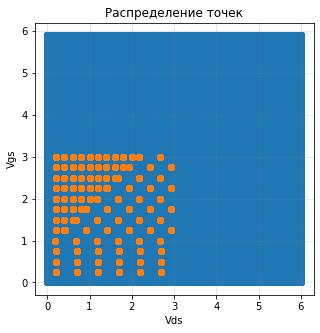

In [421]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vds']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

Посмотрим на область технических параметров

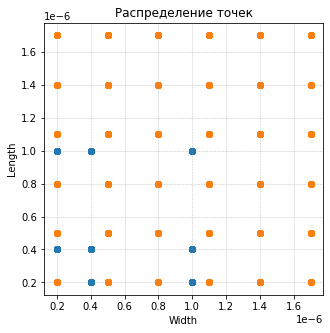

In [422]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['W']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

Вновь посчитаем сред квадр ошибку, но только теперь для внешней области

In [423]:
xval, yval, df_val = process_data(df_val_out)
y_pred = model_relu.predict(xval)
loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred))
l = keras.losses.MSE(yval, y_pred)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

1.8140365e-06 0.061951943
tf.Tensor(2.7569834e-08, shape=(), dtype=float32)


In [424]:
print_loss(df_val_out, model_relu)

max loss:  0.061951943
max post-proc loss:  1.8140365e-06
mean post-prox loss:  tf.Tensor(2.7569834e-08, shape=(), dtype=float32)


max loss:  0.019900857
max post-proc loss:  4.6900623e-06
mean post-prox loss:  tf.Tensor(9.3978755e-08, shape=(), dtype=float32)

max loss:  0.06776958
max post-proc loss:  2.028464e-06
mean post-prox loss:  tf.Tensor(2.9323372e-08, shape=(), dtype=float32)

4118/4118 [==============================] - 6s 2ms/step
max loss:  0.0042757224
max post-proc loss:  4.982407e-06
mean post-prox loss:  tf.Tensor(6.156452e-08, shape=(), dtype=float32)

In [425]:
print_loss(df_val_out, model_tanh)

max loss:  0.06860633
max post-proc loss:  2.2629922e-06
mean post-prox loss:  tf.Tensor(2.8689946e-08, shape=(), dtype=float32)


max loss:  0.044551734
max post-proc loss:  2.8279717e-05
mean post-prox loss:  tf.Tensor(5.4705964e-08, shape=(), dtype=float32)

max loss:  0.07185591
max post-proc loss:  6.060887e-05
mean post-prox loss:  tf.Tensor(1.8992623e-07, shape=(), dtype=float32)

4118/4118 [==============================] - 10s 3ms/step
max loss:  0.0042648125
max post-proc loss:  4.9740806e-06
mean post-prox loss:  tf.Tensor(6.194699e-08, shape=(), dtype=float32)

In [426]:
print_loss(df_val_out, model_srelu)

max loss:  0.06194592
max post-proc loss:  6.8492527e-06
mean post-prox loss:  tf.Tensor(1.01809995e-07, shape=(), dtype=float32)


max loss:  0.018692236
max post-proc loss:  2.6412142e-06
mean post-prox loss:  tf.Tensor(7.7605804e-08, shape=(), dtype=float32)

max loss:  0.07474155
max post-proc loss:  6.534746e-06
mean post-prox loss:  tf.Tensor(1.06733864e-07, shape=(), dtype=float32)

4118/4118 [==============================] - 10s 2ms/step
max loss:  0.0042559304
max post-proc loss:  4.967293e-06
mean post-prox loss:  tf.Tensor(6.357015e-08, shape=(), dtype=float32)

In [427]:
print_loss(df_val_out, model_stanh)

max loss:  0.058344048
max post-proc loss:  2.399656e-05
mean post-prox loss:  tf.Tensor(1.6707492e-07, shape=(), dtype=float32)


max loss:  0.036684763
max post-proc loss:  2.411517e-06
mean post-prox loss:  tf.Tensor(1.2834595e-08, shape=(), dtype=float32)

max loss:  0.11140443
max post-proc loss:  3.692214e-05
mean post-prox loss:  tf.Tensor(2.2598655e-07, shape=(), dtype=float32)

4118/4118 [==============================] - 6s 1ms/step
max loss:  0.004160908
max post-proc loss:  4.894093e-06
mean post-prox loss:  tf.Tensor(6.503205e-08, shape=(), dtype=float32)

In [428]:
print_loss(df_val_out, model_mtanh)

max loss:  0.076879404
max post-proc loss:  1.3240599e-06
mean post-prox loss:  tf.Tensor(6.20789e-08, shape=(), dtype=float32)


max loss:  0.044208538
max post-proc loss:  2.9696132e-05
mean post-prox loss:  tf.Tensor(2.3435334e-08, shape=(), dtype=float32)

max loss:  0.15740094
max post-proc loss:  9.944317e-05
mean post-prox loss:  tf.Tensor(1.9165934e-07, shape=(), dtype=float32)

4118/4118 [==============================] - 6s 1ms/step
max loss:  0.0040547466
max post-proc loss:  4.8110705e-06
mean post-prox loss:  tf.Tensor(6.581093e-08, shape=(), dtype=float32)

- для tanh:

0.0077557433 0.84016144
tf.Tensor(0.0006414045, shape=(), dtype=float32)

краказябры 

In [429]:
df1 = df_val_out.iloc[-64:-32]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

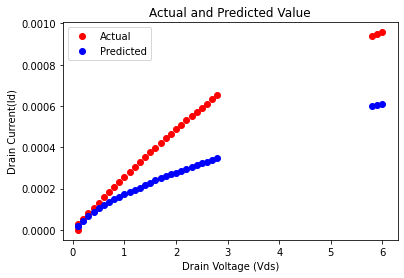

In [432]:
xval, yval, df_val = process_data(df1)
show_plot(xval, yval, df1, model_relu)

In [431]:
def show_plot(xval, yval, df, model):
  # Predict the new dataset
  y_pred = model.predict(xval)
  # y_pred_16_8_4 = model.predict(xval)
  #plot the result
  vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
  vg=np.ravel(vg1)
  vg=vg.reshape(-1,1)
  # print(vg)
  plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')
  plt.plot(vg, 10**(-1/y_pred), 'bo', label='Predicted')
  # plt.plot(vg, 10**(-1/y_pred_16_8_4), 'g', label='Predicted')
  # plt.yscale("log")
  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()

*The code presented here is a part of our model development framework. Hope, it will encourage others to develop MOSFET models based upon Neural network.*